# <font color='darkblue'>Logistic Regression with Neural Network mindset</font>

## <font color='IndianRed'>Packages</font>

- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## <font color='IndianRed'>Overview</font>

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as (y=1) or (y=0)
    - a test set of m_test images labeled as (y=1) or (y=0)
    - images is of shape (num_px, num_px, 3) where 3 is for RGB channels

In [2]:
# Loading the data
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

**Notes** 
- We added `_orig` at the end of image datasets (train and test) because we are going to preprocess. 
- After preprocessing, we will end up with `train_set_x` and `test_set_x` 
- The labels `train_set_y` and `test_set_y` don't need any preprocessing.

Each line of your `train_set_x_orig` and `test_set_x_orig` is an array representing an image. 

y = [1] ---> cat


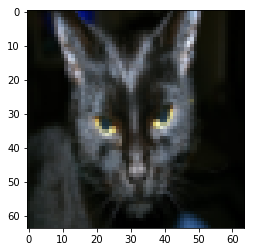

In [3]:
# Example
idx = 25
plt.imshow(train_set_x_orig[idx])
print ("y = " + str(train_set_y[:, idx]) + " ---> " + classes[np.squeeze(train_set_y[:, idx])].decode("utf-8"))

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
    
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). 

In [4]:
m_train = train_set_x_orig.shape[0]
m_test  = test_set_x_orig.shape[0]
num_px  = train_set_x_orig.shape[1]

print ("Number of training examples: m_train  = " + str(m_train))
print ("Number of testing examples : m_test   = " + str(m_test))
print ("Height/Width of each image : num_px   = " + str(num_px))

print ("Each image size is   : " + str(train_set_x_orig.shape[1:4]))
print ("train_set_x shape    : " + str(train_set_x_orig.shape))
print ("train_set_y shape    : " + str(train_set_y.shape))
print ("test_set_x  shape    : " + str(test_set_x_orig.shape))
print ("test_set_y  shape    : " + str(test_set_y.shape))

Number of training examples: m_train  = 209
Number of testing examples : m_test   = 50
Height/Width of each image : num_px   = 64
Each image size is   : (64, 64, 3)
train_set_x shape    : (209, 64, 64, 3)
train_set_y shape    : (1, 209)
test_set_x  shape    : (50, 64, 64, 3)
test_set_y  shape    : (1, 50)


For convenience, you should now reshape images of shape `(num_px, num_px, 3)` in a numpy-array of shape (num_px $\times$ num_px $\times$ 3, 1). Each image is flattened to a column vector.


**Exercise:** 

Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px $\times$ num_px $\times$ 3, 1).

A trick when you want to flatten a matrix X of shape `(a,b,c,d)` to a matrix X_flatten of shape (b$ \times $c$ \times $d, a) is to use: 

```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```
`'-1'` means to flatten with all the remaining dimensions, except the one selected i.e array.shape[0]. 
So, if your array was shape (a,b,c,d) it would flatten b,c,d. Similar arguments of shape[1]. shape[2] etc.

In [5]:
# Reshape the training and test examples

# when we collapse the other three dimension in train set, it becomes matrix of (209, ...). Each row is 
# an image. We need 209 columns (m samples), with each column being individual f.v. Hence take the transpose.

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten  = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape:         " + str(train_set_y.shape))
print ("test_set_x_flatten shape:  " + str(test_set_x_flatten.shape))
print ("test_set_y shape:          " + str(test_set_y.shape))
print ("sanity check:              " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape:         (1, 209)
test_set_x_flatten shape:  (12288, 50)
test_set_y shape:          (1, 50)
sanity check:              [17 31 56 22 33]


**Expected Output**: 

`train_set_x_flatten shape: (12288, 209)`

`train_set_y shape:         (1, 209)`

`test_set_x_flatten shape:  (12288, 50)`

`test_set_y shape:          (1, 50)`

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model.  It is extremely important for each feature to have a similar range such that our gradients don't explode.

** Excerise **
Standardize the dataset

In [6]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## <font color='IndianRed'>General Architecture of Logistic Regression</font>


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b $$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

## <font color='IndianRed'>Building the parts</font>
The main steps for building a Neural Network are:
1. Define the model structure
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

### <font color='MediumSeaGreen'>Helper functions</font> - `sigmoid`

In [7]:
# sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [8]:
print ("Test: sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

Test: sigmoid([0, 2]) = [ 0.5         0.88079708]


### <font color='MediumSeaGreen'>Helper functions</font> - `Parameter Initialization`

In [9]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    b = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [10]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = \n" + str(w))
print ("b = " + str(b))

w = 
[[ 0.]
 [ 0.]]
b = 0


### <font color='MediumSeaGreen'>Helper Function</font> - `Forward & Backward propagation`


**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

For the gradients, here are the two formulas: 

- For w,$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
- For b,$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [11]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, #examples)
    Y -- true "label" vector (containing 0 & 1) of size (1, #examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]                              # get the number of samples.
    
    # FORWARD PROPAGATION (FROM X TO COST)
   
    A    = sigmoid(np.dot(w.T, X) + b)          
    cost = (-1/m)* np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))                       
    
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m) * np.dot(X ,(A-Y).T) 
    db = (1/m) * np.sum(A-Y)
    

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [12]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = \n" + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = 
[[ 0.99845601]
 [ 2.39507239]]
db = 0.00145557813678
cost = 5.80154531939


### <font color='MediumSeaGreen'>Helper function</font> - `Optimization`

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [13]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
            
        # Cost and gradient calculation (≈ 1-4 lines of code)
        
        grads, cost = propagate(w, b, X, Y)
                
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [14]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 1000, learning_rate = 0.009, print_cost = True)

print ("w = \n" + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = \n" + str(grads["dw"]))
print ("db = " + str(grads["db"]))

Cost after iteration 0: 5.801545
Cost after iteration 100: 1.055933
Cost after iteration 200: 0.378303
Cost after iteration 300: 0.363595
Cost after iteration 400: 0.356242
Cost after iteration 500: 0.349210
Cost after iteration 600: 0.342420
Cost after iteration 700: 0.335860
Cost after iteration 800: 0.329517
Cost after iteration 900: 0.323380
w = 
[[-0.64226437]
 [-0.43498153]]
b = 2.20255947479
dw = 
[[ 0.06282959]
 [-0.01416124]]
db = -0.0484750860422


**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if $\hat{Y} <= 0.5$) or 1 (if $\hat{Y} > 0.5$); Store the predictions in a vector `Y_prediction`.

In [15]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]                     # get the size of vector
    Y_prediction = np.zeros((1,m))     # allocate as many spots in array
    w = w.reshape(X.shape[0], 1)
    
    
    A = sigmoid(np.dot(w.T,X) + b)
    Y_prediction = np.around(A)
            
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [16]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[ 1.  1.  0.]]


**Expected Output**: 

`predictions: [[ 1.  1.  0.]]`

## <font color='IndianRed'>Merge functions into model</font>

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction_test for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [17]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = True):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
        
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])   # initialize with dim of f.v

    # Gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test  = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy : {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

## <font color='IndianRed'>Training Model</font>

In [18]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, 
          num_iterations = 2000, learning_rate = 0.005, print_cost = True)

train accuracy: 99.04306220095694 %
test accuracy : 70.0 %


**Expected Output**: 

`Train Accuracy:99.04306220095694`

`Test Accuracy`: 70.0 % 

y = 0, you predicted that it is a "non-cat" picture.


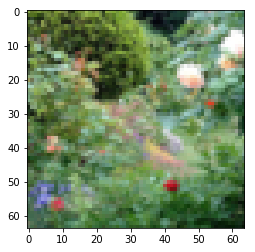

In [19]:
# Example of a picture that was wrongly classified.
index = 49
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + 
       classes[d["Y_prediction_test"][0,index]].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

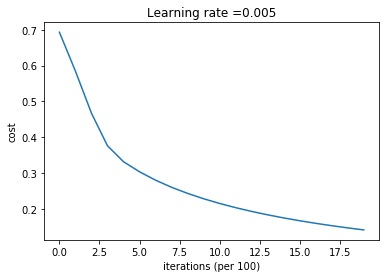

In [20]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per 100)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the <font color='red'>training set accuracy goes up, but the test set accuracy goes down. This is called Overfitting</font>

In [21]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, 
          num_iterations = 2500, learning_rate = 0.005, print_cost = True)

train accuracy: 99.52153110047847 %
test accuracy : 68.0 %


## <font color='IndianRed'>Further analysis</font>



### <font color='indigo'>Choice of learning rate</font>

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. 

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy : 68.0 %

-------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy : 64.0 %

-------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy : 36.0 %

-------------------------------------------



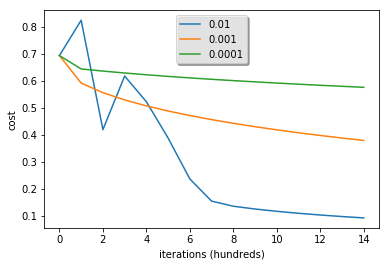

In [22]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.95')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens *when the training accuracy is a lot higher than the test accuracy*.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. 


## <font color='darkred'>Test with your own image</font>

In [23]:

# my_image = "my_image.jpg"   # change this to the name of your image file 
# fname = "images/" + my_image
# image = np.array(ndimage.imread(fname, flatten=False))
# image = image/255.
# my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
# my_predicted_image = predict(d["w"], d["b"], my_image)

# plt.imshow(image)
# print("y = " + str(np.squeeze(my_predicted_image)) + " -----> " 
#         + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8"))

## Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c